In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_dir = './datas/dogcat/modeltesting'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
    
#mobilenetv2 모델 불러오기 (사전 학습된 가중치 사용, 최상위 레이어 제거)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable=False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    epochs=10
)
model.save('./model/dogcat/catDogClassifier.keras')

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1250 - loss: 0.8558 - val_accuracy: 0.5000 - val_loss: 0.7752
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.6368 - val_accuracy: 0.7500 - val_loss: 0.5238
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - accuracy: 1.0000 - loss: 0.4532 - val_accuracy: 1.0000 - val_loss: 0.4376
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - accuracy: 1.0000 - loss: 0.3425 - val_accuracy: 1.0000 - val_loss: 0.3812
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - accuracy: 1.0000 - loss: 0.2553 - val_accuracy: 1.0000 - val_loss: 0.2648
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - accuracy: 1.0000 - loss: 0.1719 - val_accuracy: 1.0000 - val_loss: 0.2168
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1241 - val_accuracy: 1.0000 - val_loss: 0.1653
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/ste

Found 27 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0872
Validation Loss: 0.08718352019786835
Validation Accuracy: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


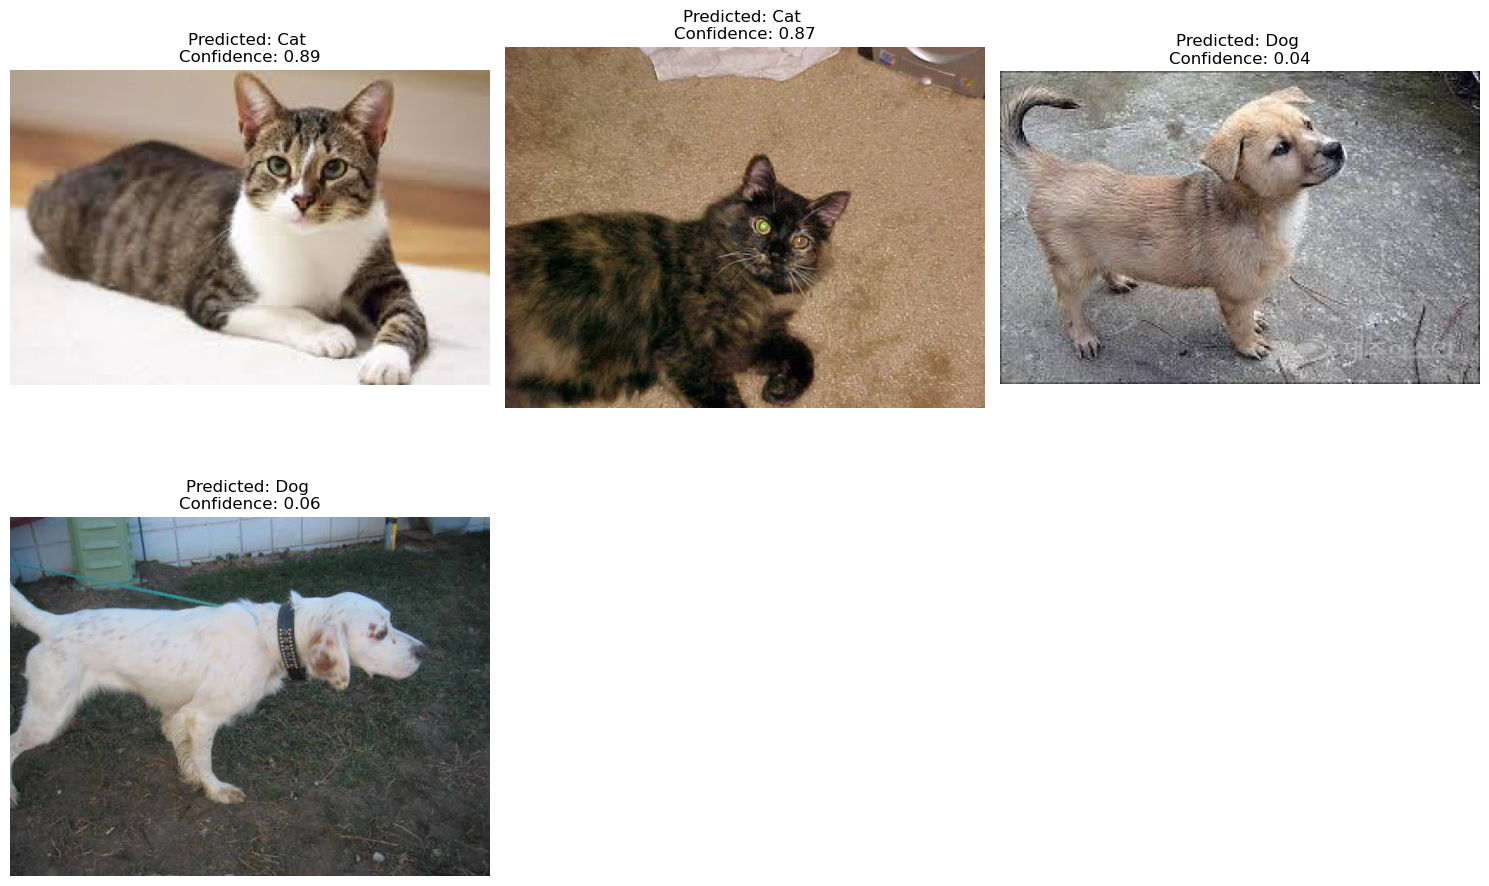

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.keras.utils.data_utils')

model = tf.keras.models.load_model('./model/dogcat/cat_dog_classifier.keras')

check_dir = './datas/dogcat/check'

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validations_generator = validation_datagen.flow_from_directory(
    check_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode = 'binary',
    shuffle = False
)

loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples)
predicted_classes = ['Dog' if p < 0.5 else 'Cat' for p in predictions]
predicted_values = predictions.flatten()

num_images = len(predicted_classes)
num_cols = 3
num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()
for ax, file, pred_class, pred_value in zip(axes, validation_generator.filenames, predicted_classes, predicted_values):
    img_path = os.path.join(check_dir, file)
    img =  plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(f'Predicted: {pred_class} \nConfidence: {pred_value:.2f}')
    ax.axis('off')

for i in range(len(predicted_classes), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()